# Unsupervised Learning <a id='unsupervised_learning'></a>

These notes follow along with **Chapter 2 of our Hull textbook**. My notes are not meant to be comprehensive. Instead, I want to provide you with some additional resources and commentary on what is in this chapter.

As noted in Chapter 2,

> ... unsupervised learning is concerned with **identifying patterns in data**. The immediate objective is not to predict  the value of a target variable. Instead, it is to understand the **structure** of data and find **clusters**.

## Feature Scaling

The chapter starts with a particular **transormation** of our data. We've already seen a bit about how to take our raw data and create new variables from it. This broad topic is called **feature engineering**. It is a crucial part of data analysis, as you are rarely taking raw data and using it to make a prediction or investigate a causal relationship.

Instead, you need to change your variables. Scale or normalize them. Create categories. Take logs. All to help with interpretation and create better models.

The purpose of feature scaling is to ensure that the features are given equal importance in a model. You're trying to capture how different a variable is from its typical value and whether or not this relates to some other value, the one that you're trying to predict.

The text discusses **normalization**. You've probably seen this calculation in your stats class.

\begin{align}
\text{Scaled Feature Value} = \frac{V - \mu}{\sigma}
\end{align}

where V is the value of an observation, $\mu$ is the mean of all of the observations, and $\sigma$ is the standard deviation of the values. This is called a **Z-score normalization**.

You can also do **min-max scaling**. 

\begin{align}
\text{Scaled Feature Value} = \frac{V - min(V)}{max(V) - min(V)}
\end{align}

Finally, note that use of **training set** and **validation set**. We are going to start splitting our data up as we use **machine learning** techniques to make predictions. We use these data sets to build our model and, in particular, look for **hyperparameters**, a subject we'll get to when discussing regression and logit in Chapter 3 of Hull. We'l also create a **testing set** where we take the trained model and see how well it **predicts values** using data we've **pulled out** and not used. 

Hull points out that, when scaling your data, you should **pull the means and standard deviations that you need from the training data**. Then, you **scale your testing data using the means and standard deviations from the training data**. That way, you're testing data never touches your training data. If you use the means and standard deviations from all of your data to scale your variables, then observations in your testing data set are altering observations in your training data set, and vice-versa.

### Additional materials on feature engineering

Here are some examples from Datacamp on [feature engineering for a Kaggle competition](https://www.datacamp.com/tutorial/feature-engineering-kaggle). Again, this is all about variable transformation and, more generally, **data engineering**. For example, see the example on **binning data**? This is like when we created some categories for house sizes in our problem sets.

Here's an [entire book on feature engineering](https://feaz-book.com). It is a work in progress, but gives you a sense for the types of transformations that you can make and why you might want to make them.

The Feature Engineering book has a section on [normalization](https://feaz-book.com/numeric-normalization).



## K-means Algorithm

**Clustering** is about grouping our data. How some observations like others? To do this, we are going to use the concept of a **distance** between observations. Are some observations closer to others, in some sense?

We are going to use [Kmeans from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). 

Our text discusses **Euclidean distance** on pgs. 25 and 26. This is like measuring the length of a line, except that you can do this in any number of dimensions.

There is also the concept of a **center** of a cluster. Suppose that a certain set of observations is regarded as a cluster. The center is calculated by averaging the values of each of the features for the observations in the cluster.


```{figure} ../images/10-kmeansalgo.png
---
name: 10-kmeansalg.png
align: center
---
How the algo works. From Hull, Chapter 2.
```

How do you know if your clustering method is any good? A measure of the performance of a clustering algorithm is the within-cluster sum of squares, also known as the **inertia**. Define $d_i$ as the  distance of the ith observation from the center of the cluster to which it belongs.

\begin{align}
\text{Inertia} = \sum_{i=1}^{N} d_i
\end{align}

The larger the inertia value, the worse the fit. Now, you can always get smaller inertia by adding more clusters. In fact, each observation could be its own cluster! But, that defeats the purpose. At some point, there's an "optimal" number of clusters to try and divide your data into.

The example below will use the **elbow method**. Sometimes, there's just a natural number of clusters that you're looking for. 

The text also discusses the **silhoutte method** and **gap method** for choosing the optimal number of clusters. You want larger silhoutte scores as you vary the number of clusters, k. You'll also see an example of this below.

Finally, the text discusses the **curse of dimensionality**. Basically, as you have more and more features, forming clusters gets difficult. There are other ways to cluster your data, beyond Euclidean Distance. For example, the text mentions **cosine similarity**.

In the example below, we'll start with four features. But, two of them are highly correlated, so we drop one. This is where **looking at and understanding your data first is crucial**.



## An example with country risk

I have re-created the code for this section below. We are now using the `scikit-learn` package. This is where the `KMeans` algo lives. I have uploaded the raw country risk data to our course Github page.

You can install `scikit-learn` with `pip`.

```

pip install -U scikit-learn

```

There is a bug with a package called `threadpoolctl` and `scikit-learn`. `threadpoolctl` needs to be version 3 or higher. This may not be an issue when running things in Github Codespaces, but it was on my local Mac install. You can get a later version by specifying the one that you want to install.

```
 pip install threadpoolctl==3.2.0

```



In [1]:
# Our set-up

import pandas as pd
import numpy as np

# plotting packages
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs

# Kmeans algorithm from scikit-learn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
# load raw data

raw = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/Country_Risk_2019_Data.csv')

# check the raw data
print("Size of the dataset (row, col): ", raw.shape)
print("\nFirst 5 rows\n", raw.head(n=5))

Size of the dataset (row, col):  (121, 6)

First 5 rows
      Country Abbrev  Corruption  Peace  Legal  GDP Growth
0    Albania     AL          35  1.821  4.546       2.983
1    Algeria     DZ          35  2.219  4.435       2.553
2  Argentina     AR          45  1.989  5.087      -3.061
3    Armenia     AM          42  2.294  4.812       6.000
4  Australia     AU          77  1.419  8.363       1.713


### Simple exploratory analysis
#### Print summary statistics
Note that all features have quite different variances, and Corruption and Legal are highly correlated.

In [3]:
# print summary statistics
print("\nSummary statistics\n", raw.describe())
print("\nCorrelation matrix\n", raw.corr())


Summary statistics
        Corruption       Peace       Legal  GDP Growth
count  121.000000  121.000000  121.000000  121.000000
mean    46.842975    2.001017    5.752529    2.657529
std     18.702499    0.461485    1.373932    2.563741
min     15.000000    1.072000    2.671000   -9.459000
25%     33.000000    1.699000    4.785000    1.249000
50%     41.000000    1.939000    5.455000    2.600000
75%     60.000000    2.294000    6.488000    4.000000
max     87.000000    3.369000    8.712000    7.800000

Correlation matrix
             Corruption     Peace     Legal  GDP Growth
Corruption    1.000000 -0.705002  0.938512   -0.123545
Peace        -0.705002  1.000000 -0.662233   -0.004428
Legal         0.938512 -0.662233  1.000000   -0.150369
GDP Growth   -0.123545 -0.004428 -0.150369    1.000000


#### Plot histogram

Note that distributions for GDP Growth is quite skewed.

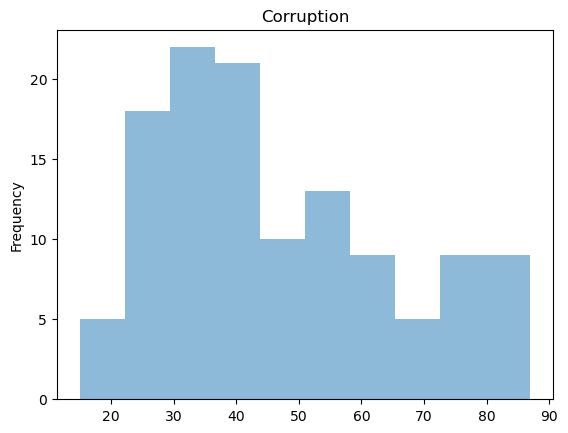

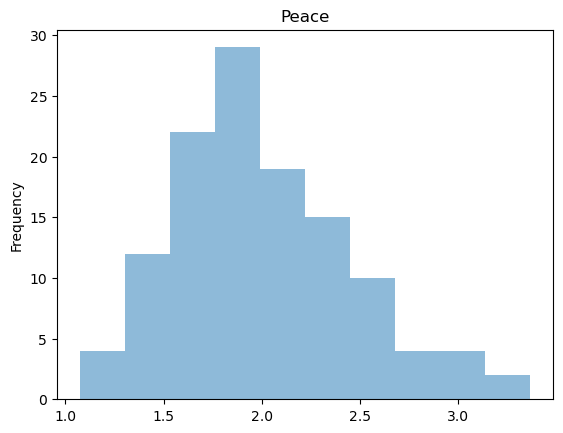

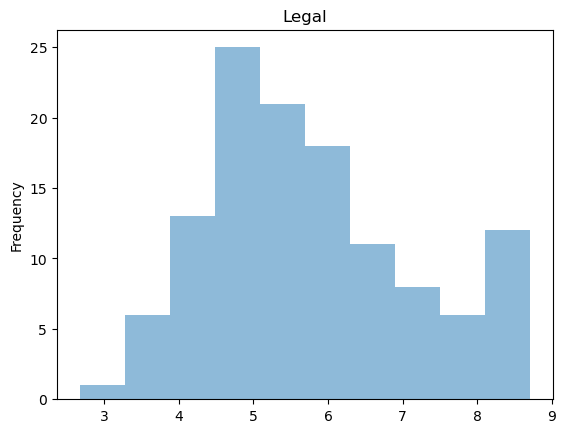

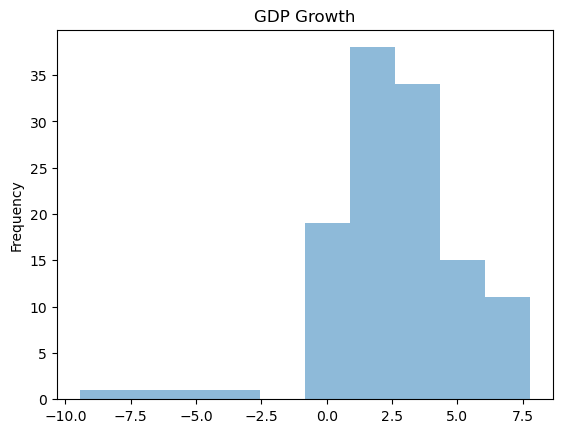

In [4]:
# plot histograms
plt.figure(1)
raw['Corruption'].plot(kind = 'hist', title = 'Corruption', alpha = 0.5)

plt.figure(2)
raw['Peace'].plot(kind = 'hist', title = 'Peace', alpha = 0.5)

plt.figure(3)
raw['Legal'].plot(kind = 'hist', title = 'Legal', alpha = 0.5)

plt.figure(4)
raw['GDP Growth'].plot(kind = 'hist', title = 'GDP Growth', alpha = 0.5)

plt.show()

### K means cluster
#### Pick features & normalization

Since Corruption and Legal are highly correlated, we drop the Courrption variable, i.e., we pick three features for this analysis, Peace, Legal and GDP Grwoth. Let's normalize all the features, effectively making them equally weighted.

Ref. [Feature normalization.](https://stats.stackexchange.com/questions/21222/are-mean-normalization-and-feature-scaling-needed-for-k-means-clustering)

In [5]:
df_features = raw[['Peace', 'Legal', 'GDP Growth']]
df_features_scaled = (df_features - df_features.mean()) / df_features.std()
df_features_scaled.head(5)

Peace     Legal  GDP Growth
0 -0.390081 -0.878158    0.126952
1  0.472352 -0.958948   -0.040772
2 -0.026039 -0.484397   -2.230541
3  0.634871 -0.684553    1.303747
4 -1.261182  1.900001   -0.368418

I've included some code to drop missing values, just in case. `Kmeans` doesn't run if any row has a missing value. Of course, if there were missing values, you'd want to understand why.

In [6]:
df_features_scaled = df_features_scaled.dropna()

In [7]:
df_features_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Peace       121 non-null    float64
 1   Legal       121 non-null    float64
 2   GDP Growth  121 non-null    float64
dtypes: float64(3)
memory usage: 3.0 KB


See, no missing values. Still 121 observations.

`scikit-learn` comes with built-in scalers. Here, I'm scaling the feature data in a similar manner. The output is an *array*, not a DataFrame. 

In [8]:
df_features_scaled2 = StandardScaler().fit_transform(df_features)
df_features_scaled2[:5,:3]


array([[-0.39170288, -0.88180929,  0.12747948],
       [ 0.47431618, -0.96293527, -0.04094156],
       [-0.02614709, -0.48641154, -2.23981529],
       [ 0.63751073, -0.68739931,  1.30916848],
       [-1.26642564,  1.90790093, -0.3699501 ]])

#### Perform elbow method

This is a way to visualize how good the fit is. There are **decreasing returns** to adding more clusters. The marginal gain of adding one cluster dropped quite a bit from k=3 to k=4. We will choose k=3 (not clear cut though).

Ref. [Determining the number of clusters in a dataset.](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set)

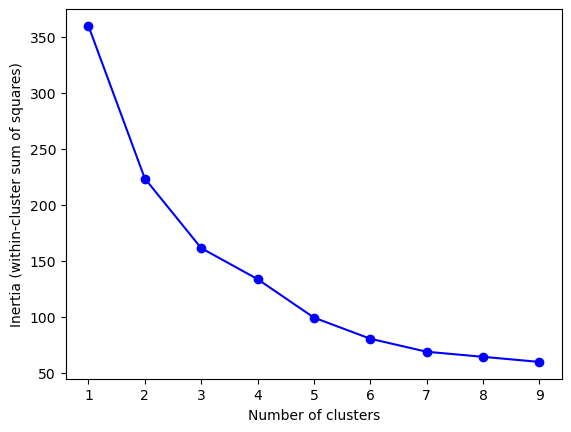

In [9]:
# https://stackoverflow.com/questions/41540751/sklearn-kmeans-equivalent-of-elbow-method

Ks = range(1, 10)
inertia = [KMeans(i).fit(df_features_scaled).inertia_ for i in Ks]

fig = plt.figure()
plt.plot(Ks, inertia, '-bo')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.show()

#### K means with k=3

Each country is getting labeled now. There are three categories (k=3).

In [10]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=1)
kmeans.fit(df_features_scaled)

# print inertia & cluster center
print("inertia for k=3 is", kmeans.inertia_)
print("cluster centers: ", kmeans.cluster_centers_)

# take a quick look at the result
y = kmeans.labels_
print("cluster labels: ", y)

inertia for k=3 is 161.2893804348309
cluster centers:  [[ 1.22973303 -0.68496051 -0.94125294]
 [ 0.16803028 -0.59729967  0.69048743]
 [-0.85097477  1.02149992 -0.23897931]]
cluster labels:  [1 1 0 1 2 2 1 0 1 2 1 1 1 2 0 1 0 1 2 0 2 1 0 2 1 2 2 0 2 1 0 1 1 2 1 2 2
 1 1 2 1 1 1 1 2 2 1 1 0 2 0 2 2 2 2 1 1 2 2 2 0 0 2 1 1 2 1 1 2 0 1 1 1 1
 1 2 2 0 0 2 2 0 1 0 1 1 2 2 2 2 0 1 0 1 1 1 2 2 2 0 2 1 2 2 2 1 1 1 0 1 0
 1 0 2 2 2 2 1 0 1 0]


#### Visualize the result (3D plot)

Three groups of countries, clustered along three dimensions of risk.

Before you make any graph, think about what you want to show and why. Sketch it on a piece of paper. You can use Chat GPT to help you with syntax **once you know what you want**. 

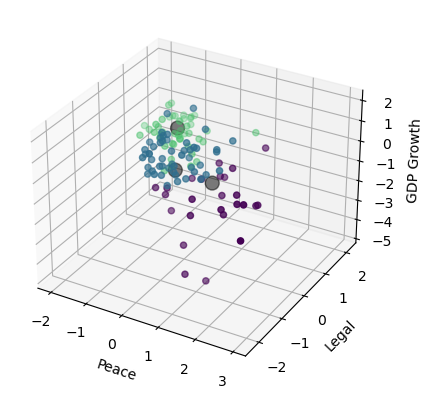

In [11]:
# set up the color
norm = clrs.Normalize(vmin=0.,vmax=y.max() + 0.8)
cmap = cm.viridis

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_features_scaled.iloc[:,0], df_features_scaled.iloc[:,1], df_features_scaled.iloc[:,2], c=cmap(norm(y)), marker='o')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

ax.set_xlabel('Peace')
ax.set_ylabel('Legal')
ax.set_zlabel('GDP Growth')

plt.show()

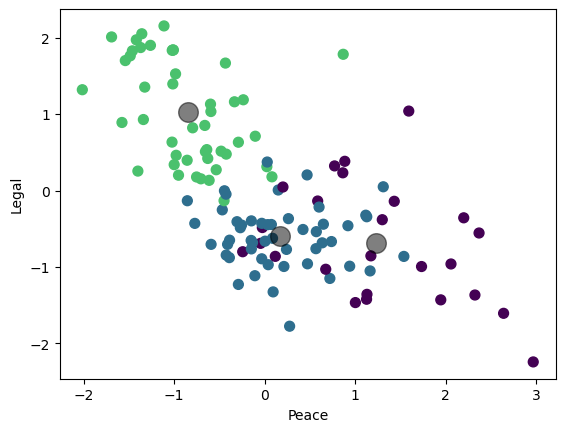

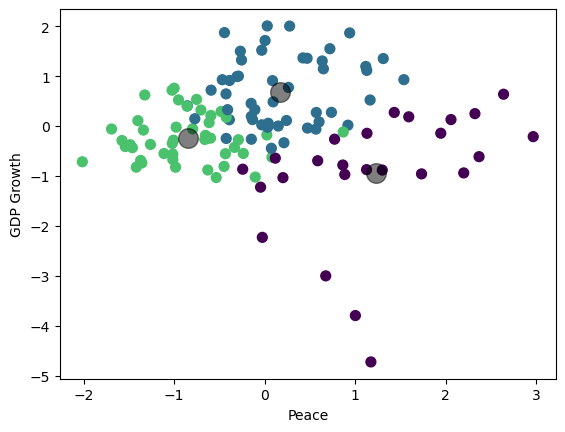

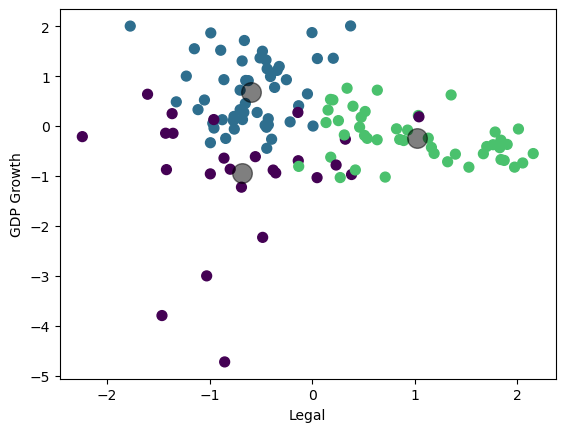

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

figs = [(0, 1), (0, 2), (1, 2)]
labels = ['Peace', 'Legal', 'GDP Growth']

for i in range(3):
    fig = plt.figure(i)
    plt.scatter(df_features_scaled.iloc[:,figs[i][0]], df_features_scaled.iloc[:,figs[i][1]], c=cmap(norm(y)), s=50)
    plt.scatter(centers[:, figs[i][0]], centers[:, figs[i][1]], c='black', s=200, alpha=0.5)
    plt.xlabel(labels[figs[i][0]])
    plt.ylabel(labels[figs[i][1]])

plt.show()

#### Visualize the result (3 2D plots)

Let's plot country abbreviations instead of dots. By being careful with our graphic design, we can show dimensionality a variety of ways. 

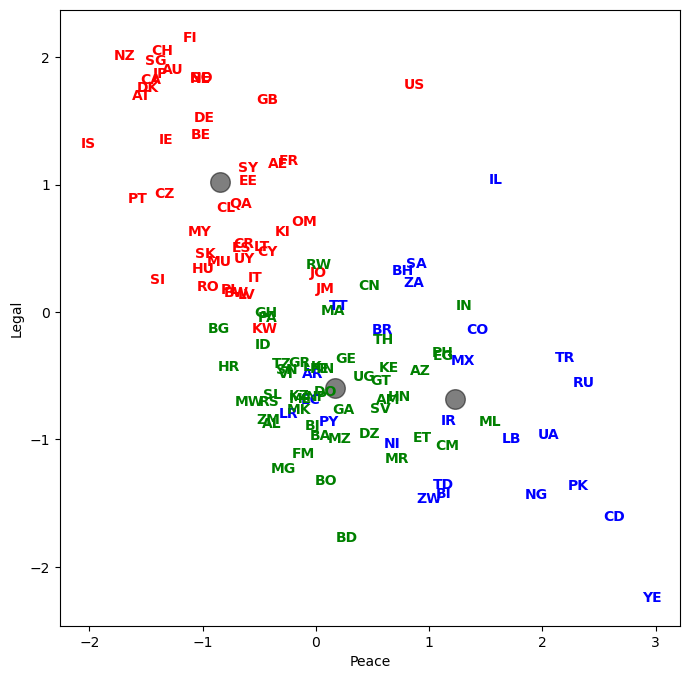

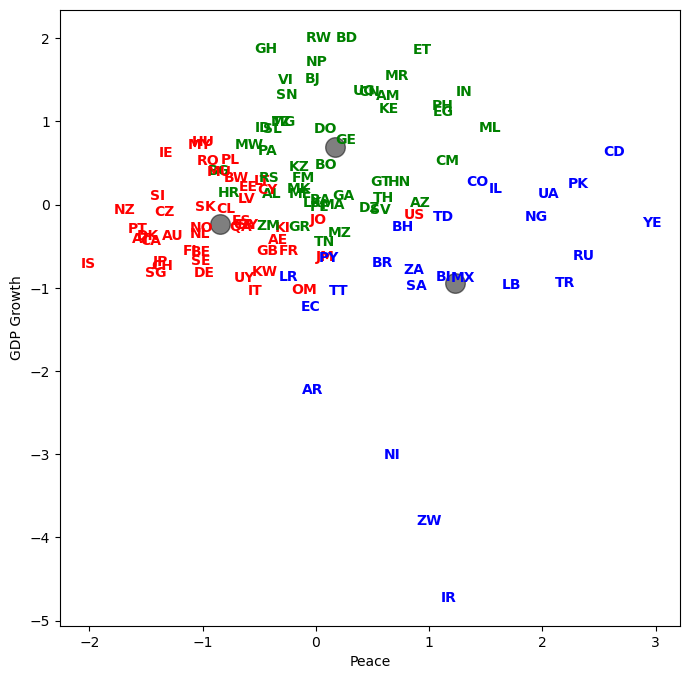

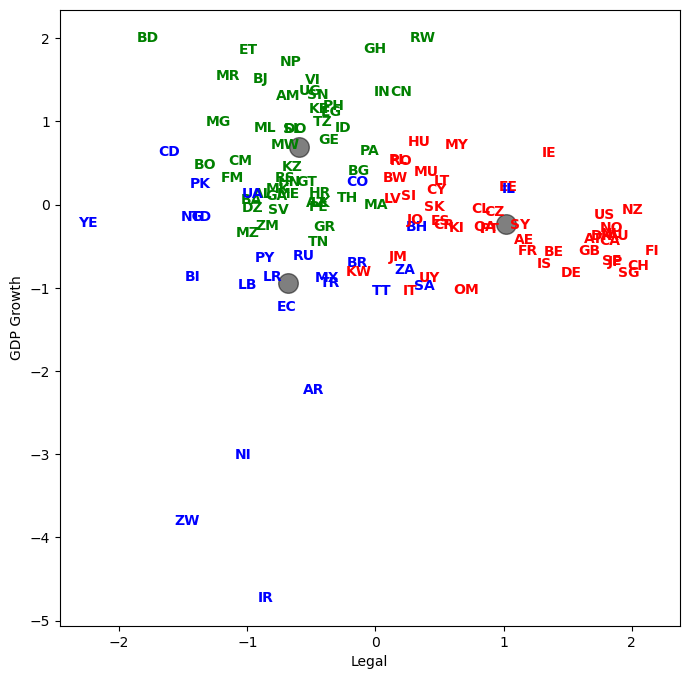

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

figs = [(0, 1), (0, 2), (1, 2)]
labels = ['Peace', 'Legal', 'GDP Growth']
colors = ['blue','green', 'red']

for i in range(3):
    fig = plt.figure(i, figsize=(8, 8))
    x_1 = figs[i][0]
    x_2 = figs[i][1]
    plt.scatter(df_features_scaled.iloc[:, x_1], df_features_scaled.iloc[:, x_2], c=y, s=0, alpha=0)
    plt.scatter(centers[:, x_1], centers[:, x_2], c='black', s=200, alpha=0.5)
    for j in range(df_features_scaled.shape[0]):
        plt.text(df_features_scaled.iloc[j, x_1], df_features_scaled.iloc[j, x_2], raw['Abbrev'].iloc[j], 
                 color=colors[y[j]], weight='semibold', horizontalalignment = 'center', verticalalignment = 'center')
    plt.xlabel(labels[x_1])
    plt.ylabel(labels[x_2])

plt.show()

#### List the result

Let's see how every country got classified. Who are in the same groups? Does this grouping make sense? 

In [14]:
result = pd.DataFrame({'Country':raw['Country'], 'Abbrev':raw['Abbrev'], 'Label':y})
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(result.sort_values('Label'))


                          Country Abbrev  Label
60                        Lebanon     LB      0
30                        Ecuador     EC      0
48                           Iran     IR      0
50                         Israel     IL      0
61                        Liberia     LR      0
69                         Mexico     MX      0
77                      Nicaragua     NI      0
78                        Nigeria     NG      0
27   Democratic Republic of Congo     CD      0
81                       Pakistan     PK      0
90                         Russia     RU      0
92                   Saudi Arabia     SA      0
99                   South Africa     ZA      0
108           Trinidad and Tobago     TT      0
110                        Turkey     TR      0
112                       Ukraine     UA      0
118                         Yemen     YE      0
83                       Paraguay     PY      0
22                       Colombia     CO      0
120                      Zimbabwe     ZW

#### Silhouette Scores

A larger score is better. Note how `scikit-learn` has these features built-in. We don't have to do the calculation ourselves.

In [15]:
# Silhouette Analysis
range_n_clusters=[2,3,4,5,6,7,8,9,10]
for n_clusters in range_n_clusters:
    clusterer=KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels=clusterer.fit_predict(df_features_scaled)
    silhouette_avg=silhouette_score(df_features_scaled,cluster_labels)
    print("For n_clusters=", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters= 2 The average silhouette_score is : 0.35091395238521605
For n_clusters= 3 The average silhouette_score is : 0.35287972873953516
For n_clusters= 4 The average silhouette_score is : 0.3162677855568406
For n_clusters= 5 The average silhouette_score is : 0.2769522059777643
For n_clusters= 6 The average silhouette_score is : 0.33582504378732997
For n_clusters= 7 The average silhouette_score is : 0.311002099095008
For n_clusters= 8 The average silhouette_score is : 0.35010275097023785
For n_clusters= 9 The average silhouette_score is : 0.3459688066178027
For n_clusters= 10 The average silhouette_score is : 0.31726760014278527


## Principal Component Analysis (PCA)

Chapter 2 ends with some alternative clustering methods, including **principal component analysis (PCA)**.

PCA takes the data features and creates **factors** from the data that are **uncorrelated** with each other. From pg. 42:

> PCA works best on normalized data. The first factor accounts for as  much of the variability in the data as possible. Each succeeding factor  then accounts for as much of the remaining variability in the data subject to the condition that it is uncorrelated to preceding factors. The  quantity of a particular factor in a particular observation is the factor score. 

You can read more about how to do this with [Scikit-learn PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

What is PCA really doing? Well, you need some [matrix algebra for that](https://brilliant.org/wiki/principal-component-analysis/). Here's [another explainer](https://www.avenga.com/magazine/pca-in-finance/), with the bare-minimum of math.


In [16]:
from sklearn.decomposition import PCA

df_features_scaled_pca = raw[['Corruption', 'Peace', 'Legal', 'GDP Growth']]

df_features_scaled_pca = (df_features_scaled_pca - df_features_scaled_pca.mean()) / df_features_scaled_pca.std()
df_features_scaled_pca.head(5)


Corruption     Peace     Legal  GDP Growth
0   -0.633230 -0.390081 -0.878158    0.126952
1   -0.633230  0.472352 -0.958948   -0.040772
2   -0.098542 -0.026039 -0.484397   -2.230541
3   -0.258948  0.634871 -0.684553    1.303747
4    1.612460 -1.261182  1.900001   -0.368418

The code below defines an object called *pca*. We then apply the method `.fit` to this object using the full set of scaled data - I didn't drop Corruption this time. 

In [17]:
pca = PCA(n_components=4)
pca.fit(df_features_scaled_pca)


PCA(n_components=4)

I can then look at the output. This is called the **attributes** of the model.

For example, `pca.components` prints the four principle components for the four features in our data. These match up with pg. 44 of the text. Note how the signs can be reversed and it doesn't matter, as Hull mentions.

In [18]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_)

[0.64020312 0.25059185 0.09438808 0.01481695]
[17.52990289 10.96741031  6.73099393  2.66685887]
[[-0.60188457  0.52361257 -0.59403386  0.10338576]
 [-0.01512074  0.20084677  0.02192676 -0.97926051]
 [ 0.32824929  0.82539386  0.42519586  0.17374078]
 [ 0.72784526  0.06492634 -0.68253313 -0.01320492]]


Hull notes when PCA is used. In particular, we can use it to shrink the number of features in our models. It can combine features together. 

> PCA is sometimes used in supervised learning as well as unsupervised learning. We can use it to replace a long list of features by a much smaller list of manufactured features derived from a PCA. The manufactured features are chosen so that they account for most of the variability in the data we are using for prediction and have the nice property that they are uncorrelated. 

In other words, PCA can be used to take thousands or millions of columns (variables or features) and reduce them to just a few that contain the **important** variation in our data.

One example, often cited, is using PCA to **shrink** the number of factors in a [variance-covariance matrix](https://www.ocean.washington.edu/courses/ess522/lectures/14_covarianceandPCA.pdf). From the linked lecture note from the University of Washington:

> Principal component analysis is a tool that is commonly used in exploratory data analysis and predictive analysis, which seeks to explain the bulk of the variation in demeaned data in terms of a smaller number of uncorrelated derived variables (principal components). 
